# Multi-Agent Bidding (Baselines)

In this walkthrough, we'll provide a brief example of how to use the custom bidding environment, as well as implementing some baselines. 

### Custom Environment Interaction

In [2]:
# imports
import gymnasium as gym
from torch.utils.tensorboard import SummaryWriter
import numpy as np
%load_ext tensorboard

# stable baselines
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env

# custom environment
from envs.bidding import BiddingEnv

env = BiddingEnv()

env.render(mode='verbose') # choose from verbose, bids, plot

Step: 0

Robots:
  Robot 1: Robot at (5, 6) with type embedbot
  Robot 2: Robot at (4, 3) with type navbot
  Robot 3: Robot at (2, 3) with type humanbot
  Robot 4: Robot at (9, 2) with type humanbot
  Robot 5: Robot at (0, 0) with type embedbot
  Robot 6: Robot at (6, 7) with type navbot
  Robot 7: Robot at (8, 1) with type navbot
  Robot 8: Robot at (9, 7) with type navbot
  Robot 9: Robot at (1, 5) with type humanbot

Tasks:
  Task 1: Task at (3, 1) with prize 67 and type transport
  Task 2: Task at (6, 6) with prize 72 and type specialty
  Task 3: Task at (8, 4) with prize 81 and type specialty
  Task 4: Task at (9, 6) with prize 93 and type manipulation
  Task 5: Task at (8, 7) with prize 97 and type specialty
  Task 6: Task at (1, 8) with prize 9 and type transport

Bidding Matrix:
╒══════════╤══════════╤══════════╤══════════╤══════════╤══════════╕
│   Task 1 │   Task 2 │   Task 3 │   Task 4 │   Task 5 │   Task 6 │
╞══════════╪══════════╪══════════╪══════════╪══════════╪══════════

In [3]:
obs = env.reset()

# print('Observation space: \n', env.observation_space)
# print('Action space: \n', env.action_space)
# print('Random Action (Bid Matrix): \n', env.action_space.sample())
# print('Random Observation: \n', env.observation_space.sample()['robot_0_self_state'])
env.render(mode='verbose')

# for step in range(10):
    
#     obs, reward, done, truncated, info = env.step(env.action_space.sample())
#     print(f'\n Step {step + 1} with reward = {reward}')

#     if done:
#         env.render(mode='verbose')
#         print("Completed, final reward =", reward)
#         break

Step: 0

Robots:
  Robot 1: Robot at (7, 4) with type humanbot
  Robot 2: Robot at (9, 8) with type navbot
  Robot 3: Robot at (6, 0) with type humanbot
  Robot 4: Robot at (2, 6) with type embedbot
  Robot 5: Robot at (0, 3) with type navbot
  Robot 6: Robot at (9, 1) with type navbot
  Robot 7: Robot at (7, 7) with type embedbot
  Robot 8: Robot at (1, 4) with type embedbot
  Robot 9: Robot at (4, 0) with type embedbot

Tasks:
  Task 1: Task at (2, 3) with prize 20 and type specialty
  Task 2: Task at (0, 1) with prize 50 and type transport
  Task 3: Task at (1, 2) with prize 13 and type specialty
  Task 4: Task at (7, 4) with prize 80 and type transport
  Task 5: Task at (3, 0) with prize 8 and type specialty
  Task 6: Task at (5, 5) with prize 91 and type transport

Bidding Matrix:
╒══════════╤══════════╤══════════╤══════════╤══════════╤══════════╕
│   Task 1 │   Task 2 │   Task 3 │   Task 4 │   Task 5 │   Task 6 │
╞══════════╪══════════╪══════════╪══════════╪══════════╪══════════╡

### Benchmarking with Stable Baselines

In [4]:
env = BiddingEnv()

# check stable baselines compatibility
check_env(env, warn=True)

# tensorboard logging
tensorboard_log_dir = "./runs/baselines/bidding_stable_baselines"

/Users/devg/robopt/.venv/lib/python3.11/site-packages/stable_baselines3/common/env_checker.py:263: UserWarning: Your observation robot_0_bidding_matrix has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(
/Users/devg/robopt/.venv/lib/python3.11/site-packages/stable_baselines3/common/env_checker.py:263: UserWarning: Your observation robot_1_bidding_matrix has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(
/Users/devg/robopt/.venv/lib/python3.11/site-packages/stable_baselines3/common/env_checker.py:263: UserWarning: Your observation robot_2_bidding_matrix has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or

In [9]:
# 1) baseline random policy
class RandomPolicy:
    def __init__(self, action_space):
        self.action_space = action_space

    def predict(self, observation):
        return self.action_space.sample()

# tensorboard random policy
log_dir = "./runs/baselines/random_policy"
writer = SummaryWriter(log_dir)

# evaluate random policy
random_policy = RandomPolicy(env.action_space)
obs, _ = env.reset(seed=42)
total_reward = 0

action_mean, action_std, rewards = [], [], []

for step in range(1000):  # 1000 steps for example
    action = random_policy.predict(obs)

    obs, reward, done, _, _ = env.step(action)
    total_reward += reward

    # log to tensorboard
    writer.add_scalar("Random_Policy/AvgBid", np.mean(action), step)
    writer.add_scalar("Random_Policy/StdBid", np.std(action), step)
    writer.add_scalar("Random_Policy/Reward", reward, step)

    action_mean.append(np.mean(action))
    action_std.append(np.std(action))
    rewards.append(reward)

    # print('avg bid of ', np.mean(action), ' with std of ', np.std(action), ' gave reward of ', reward)

    if done:
        obs, _ = env.reset()

print(f"Total reward for random policy: {total_reward}")

writer.close() # close tensorboard writer

Total reward for random policy: 48787.523153037924


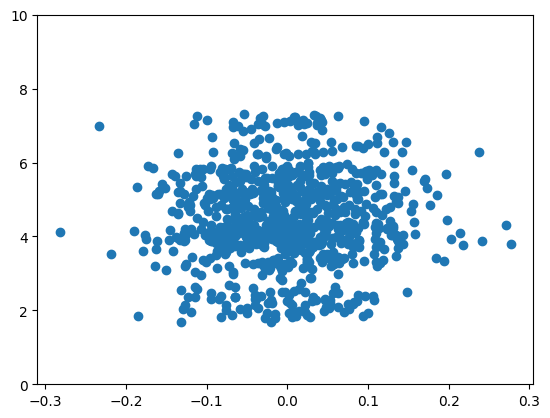

In [18]:
import matplotlib.pyplot as plt

plt.scatter(action_mean, rewards)
plt.ylim((0, 10))
plt.show()

In [ ]:
# 2) baseline ppo policy
vec_env = make_vec_env(lambda: BiddingEnv(), n_envs=1) # vectorize env for ppo
ppo_model = PPO("MultiInputPolicy", vec_env, verbose=1, tensorboard_log="./runs/baselines/sb3_ppo")
ppo_model.learn(total_timesteps=100000)

ppo_model.load

# evaluate ppo policy
mean_reward, std_reward = evaluate_policy(ppo_model, vec_env, n_eval_episodes=10)
print(f"Mean reward for PPO: {mean_reward}, Std: {std_reward}")

# close envs (unnecessary in exisitng close() implementation)
vec_env.close()

Using cpu device
Logging to ./runs/baselines/sb3_ppo/PPO_2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10       |
|    ep_rew_mean     | 495      |
| time/              |          |
|    fps             | 3947     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10          |
|    ep_rew_mean          | 495         |
| time/                   |             |
|    fps                  | 2676        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.023997178 |
|    clip_fraction        | 0.292       |
|    clip_range           | 0.2         |
|    entropy_loss         | -76.6       |
|    explaine

In [29]:
# 3) baseline heuristic policy
class HeuristicPolicy:
    def __init__(self, bidding_matrix):
        self.bidding_matrix = bidding_matrix

    def predict(self, observation):
        # given prize range is (0, 4), always bid 2
        return np.ones(self.bidding_matrix.shape) * 1

# tensorboard random policy
log_dir = "./runs/baselines/heuristic_policy"
writer = SummaryWriter(log_dir)

# evaluate heuristic policy
heuristic_policy = HeuristicPolicy(env.bidding_matrix)
obs, _ = env.reset(seed=42)
total_reward = 0

for _ in range(1000):  # 1000 steps for example
    action = heuristic_policy.predict(obs)
    obs, reward, done, _, _ = env.step(action)
    total_reward += reward

    # log to tensorboard
    writer.add_scalar("Random_Policy/AvgBid", np.mean(action), step)
    writer.add_scalar("Random_Policy/StdBid", np.std(action), step)
    writer.add_scalar("Random_Policy/Reward", reward, step)

    if done:
        obs, _ = env.reset()

print(f"Total reward for heuristic policy: {total_reward}")

writer.close() # close tensorboard writer

Total reward for heuristic policy: -1777.2110281092396
